In [1]:
!pip install transformers datasets scikit-learn --quiet

import pandas as pd
import torch
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from transformers import AutoTokenizer, AutoModel, TrainingArguments, Trainer
import torch.nn as nn
from torch.utils.data import Dataset
import numpy as np
# from google.colab import drive



[notice] A new release of pip is available: 25.0.1 -> 25.1.1
[notice] To update, run: python3 -m pip install --upgrade pip


/home/dsai_247056015/.local/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2025-06-14 00:43:38.057505: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-06-14 00:43:38.101748: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-06-14 00:43:38.101798: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-06-14 00:43:38.102

## ✅ 2. Baca Dataset

In [2]:
# drive.mount('/content/drive')

file_path = "https://raw.githubusercontent.com/gikirima/indonews-scrapper/refs/heads/main/gpt-4-annotated-dataset.csv"  # ganti sesuai lokasi kamu
df = pd.read_csv(file_path)

# Cek struktur
print(df.columns)
print(df['clickbait_label'].unique())
print(df['kategori'].unique())


Index(['agreement', 'annotation_id', 'annotator', 'clickbait_label',
       'created_at', 'id', 'isi', 'judul', 'kategori', 'lead_time', 'link',
       'sumber', 'updated_at'],
      dtype='object')
['teasing' 'non clickbait' 'exaggeration' 'misleading']
['Crypto' 'Lifestyle' 'Hot' ... 'Kabupaten Bandung' 'Sumut TERKINI'
 'Minahasa Utara']


In [3]:
# drop columns yang tidak diperlukan
df = df[['judul', 'isi','clickbait_label', 'kategori']]
df.drop_duplicates(inplace=True)

df = df.dropna(subset=['judul', 'isi', 'clickbait_label', 'kategori'])
df.describe()

,judul,isi,clickbait_label,kategori
count,8696,8696,8696,8696
unique,8691,3297,4,5642
top,Presiden Prabowo Targetkan Masalah Sampah Tunt...,Beauty,non clickbait,BOLA
freq,2,952,5700,257


In [4]:
# drop yang isinya kosong
df = df[df['judul'].str.strip() != '']
df = df[df['isi'].str.strip() != '']
df = df[df['clickbait_label'].str.strip() != '']
df = df[df['kategori'].str.strip() != '']
df = df[:100]

### ✅ 3. Label Encoding (6 Kelas)

In [5]:
le_clickbait = LabelEncoder()
le_kategori = LabelEncoder()
df["label_encoded"] = le_clickbait.fit_transform(df["clickbait_label"])
df["kategori_encoded"] = le_kategori.fit_transform(df["kategori"])

print("Label setelah encoding:", df["label_encoded"].unique())
print("Kategori setelah encoding:", df["kategori_encoded"].unique())

print("Mapping label:", dict(zip(le_clickbait.classes_, le_clickbait.transform(le_clickbait.classes_))))
print("Mapping kategori:", dict(zip(le_kategori.classes_, le_kategori.transform(le_kategori.classes_))))


Label setelah encoding: [3 2 0 1]
Kategori setelah encoding: [ 4 10  8  0 13 12  3  6  7  1 11  2 15 17 16  5  9 14]
Mapping label: {'exaggeration': 0, 'misleading': 1, 'non clickbait': 2, 'teasing': 3}
Mapping kategori: {'Bisnis': 0, 'Bola': 1, 'Cek Fakta': 2, 'Citizen6': 3, 'Crypto': 4, 'Disabilitas': 5, 'Global': 6, 'Health': 7, 'Hot': 8, 'Islami': 9, 'Lifestyle': 10, 'On Off': 11, 'Opini': 12, 'Otomotif': 13, 'Regional': 14, 'Saham': 15, 'ShowBiz': 16, 'Tekno': 17}


### ✅ 4. Split Train/Val/Test

In [6]:
X = df[["judul", "isi"]]
y = df[["label_encoded", "kategori_encoded"]]

train_texts, temp_texts, train_labels, temp_labels = train_test_split(
    X, y, test_size=0.3, stratify=df["label_encoded"], random_state=42
)

val_texts, test_texts, val_labels, test_labels = train_test_split(
    temp_texts, temp_labels, test_size=0.5, random_state=42
)

# 2. Ambil masing-masing kolom sebagai list string
train_judul = train_texts["judul"].tolist()
train_isi   = train_texts["isi"].tolist()
val_judul   = val_texts["judul"].tolist()
val_isi     = val_texts["isi"].tolist()

### ✅ 5. Tokenisasi IndoBERT

In [7]:
tokenizer = AutoTokenizer.from_pretrained("indobenchmark/indobert-base-p1")
max_len = 512

# 3. Tokenisasi dua input (judul dan isi)
train_encodings = tokenizer(
    train_judul,
    train_isi,
    truncation=True,
    padding=True,
    max_length=max_len
)
val_encodings = tokenizer(
    val_judul,
    val_isi,
    truncation=True,
    padding=True,
    max_length=max_len
)

/home/dsai_247056015/.local/lib/python3.10/site-packages/huggingface_hub/file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


In [8]:
# bagi y menjadi dua label terpisah
train_clickbait_labels = train_labels["label_encoded"].tolist()
train_kategori_labels  = train_labels["kategori_encoded"].tolist()

val_clickbait_labels = val_labels["label_encoded"].tolist()
val_kategori_labels  = val_labels["kategori_encoded"].tolist()

### ✅ 6. PyTorch Dataset

In [9]:
class ClickbaitDataset(Dataset):
    def __init__(self, encodings, clickbait_labels, kategori_labels):
        self.encodings = encodings
        self.clickbait_labels = clickbait_labels 
        self.kategori_labels = kategori_labels

    def __len__(self):
        return len(self.clickbait_labels)
    
    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item["clickbait_labels"] = torch.tensor(self.clickbait_labels[idx], dtype=torch.long)
        item["kategori_labels"] = torch.tensor(self.kategori_labels[idx], dtype=torch.long)

        return item



train_dataset = ClickbaitDataset(train_encodings, train_clickbait_labels, train_kategori_labels)
val_dataset   = ClickbaitDataset(val_encodings, val_clickbait_labels, val_kategori_labels)


### ✅ 7. Bangun Model IndoBERT Kustom Multitask-learning

In [10]:
class IndoBERTClassifier(nn.Module):
    def __init__(self, model_name, num_clickbait_labels, num_kategori_labels):
        super(IndoBERTClassifier, self).__init__()
        self.bert = AutoModel.from_pretrained(model_name)
        self.dropout = nn.Dropout(0.3)
        hidden_size = self.bert.config.hidden_size

        self.num_clickbait_labels = num_clickbait_labels
        self.num_kategori_labels = num_kategori_labels

        self.clickbait_classifier = nn.Linear(hidden_size, num_clickbait_labels)
        self.kategori_classifier = nn.Linear(hidden_size, num_kategori_labels)

    def forward(self, input_ids, attention_mask, clickbait_labels=None, kategori_labels=None):
        output = self.bert(input_ids=input_ids, attention_mask=attention_mask)
        pooled_output = output.last_hidden_state[:, 0, :]  # [CLS]
        
        dropout_output = self.dropout(pooled_output)
        clickbait_logits = self.clickbait_classifier(dropout_output)
        kategori_logits = self.kategori_classifier(dropout_output)

        loss = None
        if clickbait_labels is not None and kategori_labels is not None:
            loss_fct = nn.CrossEntropyLoss()
            loss_clickbait = loss_fct(clickbait_logits.view(-1, self.num_clickbait_labels), clickbait_labels.view(-1))
            loss_kategori = loss_fct(kategori_logits.view(-1, self.num_kategori_labels), kategori_labels.view(-1))
            loss = loss_clickbait + loss_kategori # total loss bisa ditambahkan atau dibagi 2
        return {"loss": loss, "clickbait_logits": clickbait_logits, "kategori_logits": kategori_logits}


### ✅ 8. Trainer Setup dan Training

In [11]:
model = IndoBERTClassifier(
    "indobenchmark/indobert-base-p1", 
    num_clickbait_labels=len(le_clickbait.classes_), 
    num_kategori_labels=len(le_kategori.classes_)
    )

training_args = TrainingArguments(
    output_dir="./results",
    num_train_epochs=3,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    eval_steps=3,
    evaluation_strategy="steps",  
    save_total_limit=1,
    logging_dir="./logs",
    logging_steps=10,
    report_to="none",
    remove_unused_columns=False,
    save_strategy="steps",
    logging_strategy="steps"
)

# === Custom collate function ===
def custom_collate_fn(batch):
    return {
        "input_ids": torch.stack([item["input_ids"] for item in batch]),
        "attention_mask": torch.stack([item["attention_mask"] for item in batch]),
        "clickbait_labels": torch.tensor([item["clickbait_labels"] for item in batch]),
        "kategori_labels": torch.tensor([item["kategori_labels"] for item in batch]),

    }

# Custom Trainer untuk multi-task
class MultiTaskTrainer(Trainer):
    def compute_loss(self, model, inputs, return_outputs=False):
        clickbait_labels = inputs.pop("clickbait_labels")
        kategori_labels  = inputs.pop("kategori_labels") 
        outputs = model(**inputs, clickbait_labels=clickbait_labels, kategori_labels=kategori_labels)
        loss = outputs["loss"]

        return (loss, outputs) if return_outputs else loss

trainer = MultiTaskTrainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    data_collator=custom_collate_fn,
)

/usr/local/lib/python3.10/dist-packages/accelerate/accelerator.py:432: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches', 'even_batches', 'use_seedable_sampler']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False, even_batches=True, use_seedable_sampler=True)
  warnings.warn(


### ✅ 9. Jalankan Training

In [12]:
trainer.train()

/usr/local/lib/python3.10/dist-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


Step,Training Loss,Validation Loss
3,No log,3.493270
6,No log,2.923614
9,No log,2.792248


TrainOutput(global_step=9, training_loss=3.4007169935438366, metrics={'train_runtime': 5.2432, 'train_samples_per_second': 40.052, 'train_steps_per_second': 1.717, 'total_flos': 0.0, 'train_loss': 3.4007169935438366, 'epoch': 3.0})

### ✅ A. Evaluasi Model

In [13]:
from sklearn.metrics import classification_report, accuracy_score

# 1. Dapatkan prediksi dari data validasi
preds_output = trainer.predict(val_dataset)

# Misal model mengembalikan dua output:
pred_clickbait_logits, pred_kategori_logits = preds_output.predictions

# Ambil prediksi masing-masing task:
pred_clickbait = torch.argmax(torch.tensor(pred_clickbait_logits), dim=1)
pred_kategori  = torch.argmax(torch.tensor(pred_kategori_logits), dim=1)

# Label ground-truth
labels_clickbait = torch.tensor([x["clickbait_labels"] for x in val_dataset])
labels_kategori  = torch.tensor([x["kategori_labels"] for x in val_dataset])

# Pisahkan logits
logits_clickbait = preds_output.predictions[0]
logits_kategori = preds_output.predictions[1]

all_kategori_labels = np.arange(len(le_kategori.classes_))

# 3. Evaluasi
print("✅ Classification Report:")
print(classification_report(labels_clickbait, pred_clickbait, target_names=le_clickbait.classes_))
print(classification_report(labels_kategori, pred_kategori, labels=all_kategori_labels, target_names=le_kategori.classes_, zero_division=0))

# Evaluasi Kategori
print("📌 [Kategori]")
print("Accuracy:", accuracy_score(labels_kategori, pred_kategori))
# Evaluasi Clickbait
print("📌 [Clickbait]")
print("Accuracy:", accuracy_score(labels_clickbait, pred_clickbait))



✅ Classification Report:
               precision    recall  f1-score   support

 exaggeration       0.00      0.00      0.00         2
   misleading       0.00      0.00      0.00         1
non clickbait       0.73      1.00      0.85        11
      teasing       0.00      0.00      0.00         1

     accuracy                           0.73        15
    macro avg       0.18      0.25      0.21        15
 weighted avg       0.54      0.73      0.62        15

              precision    recall  f1-score   support

      Bisnis       0.00      0.00      0.00         1
        Bola       1.00      1.00      1.00         2
   Cek Fakta       0.00      0.00      0.00         1
    Citizen6       0.00      0.00      0.00         0
      Crypto       0.67      1.00      0.80         2
 Disabilitas       0.00      0.00      0.00         0
      Global       0.00      0.00      0.00         0
      Health       0.00      0.00      0.00         1
         Hot       0.00      0.00      0.00  

/home/dsai_247056015/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/dsai_247056015/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/dsai_247056015/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result)

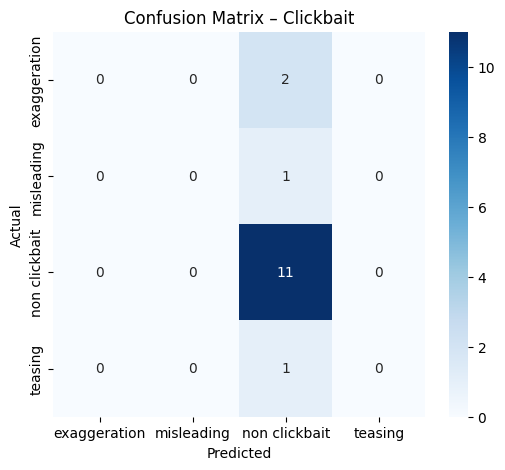

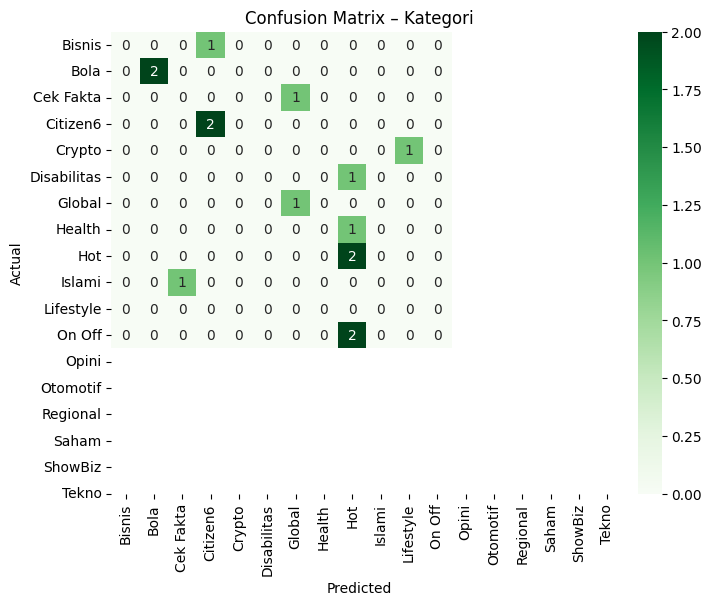

In [14]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Confusion matrix untuk Clickbait
cm_clickbait = confusion_matrix(labels_clickbait, pred_clickbait)
plt.figure(figsize=(6,5))
sns.heatmap(cm_clickbait, annot=True, fmt="d", cmap="Blues",
            xticklabels=le_clickbait.classes_,
            yticklabels=le_clickbait.classes_)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix – Clickbait")
plt.show()

# Confusion matrix untuk Kategori
cm_kategori = confusion_matrix(labels_kategori, pred_kategori)
plt.figure(figsize=(8,6))
sns.heatmap(cm_kategori, annot=True, fmt="d", cmap="Greens",
            xticklabels=le_kategori.classes_,
            yticklabels=le_kategori.classes_)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix – Kategori")
plt.show()


### ✅ B. Simpan Model ke Google Drive (format .bin)

In [15]:
import os

save_path = "/content/drive/MyDrive/S2 Data Sains/Semester 2/Komputasi Linguistik/Project Tugas Kurasi Data"
os.makedirs(save_path, exist_ok=True)


PermissionError: [Errno 13] Permission denied: '/content'

simpan model dan tokenizer

In [ ]:
# Simpan model
torch.save(model.state_dict(), os.path.join(save_path, "pytorch_model.bin"))

# Simpan tokenizer
tokenizer.save_pretrained(save_path)
model.bert.config.save_pretrained(save_path)